In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import operator
import time
import xgboost as xgb
from xgboost import plot_importance  #画特征重要性的函数
#from imblearn.ensemble import EasyEnsemble  #还有模块木有安装
from sklearn.model_selection import train_test_split
from sklearn.externals import joblib #已经改成了下面这种方式
#import joblib
from sklearn.metrics import auc,roc_curve  #说明是分类
plt.rc('font',family='SimHei',size=13)   #使画出的图形中能正常显示中文
%matplotlib inline

In [12]:
#训练数据、线上数据(无Y)、验证数据
train_data = pd.read_csv('C:/Users/Wu Ran/Desktop/train.csv')
print(len(train_data[train_data['label']==1]),len(train_data[train_data['label']==0]))  # 1: 815  0:42688
#online_data = pd.read_csv('F:\\win10 升级桌面数据备份\\3.学习模型\\online_user_model_feat.csv')
valid_data = pd.read_csv('C:/Users/Wu Ran/Desktop/test.csv')
print(len(valid_data[valid_data['label']==1]),len(valid_data[valid_data['label']==0]))  # 1:892   0:39302

162 1237
78 621


In [13]:
train_y = train_data[['label']]
train_y.columns = ['y']
train_x = train_data.drop(['label'],axis=1)

valid_y = valid_data[['label']]
valid_y.columns = ['y']
valid_x = valid_data.drop(['label'],axis=1)
# 
file_xgboost_model='./xgboost_model' #模型文件
file_xgboost_columns='./columns.csv' #最终使用的特征
file_xgboost_model_auc_ks='./xgboost_model_auc_ks.png' #模型AUC和KS值
file_xgboost_model_score='./xgboost_model_score.png' # 模型预测用户的评分分布
file_xgboost_model_prob='./xgboost_model_prob.png' #模型预测用户的概率分布

In [14]:
#coding=utf-8
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV  #网格搜索法
import xgboost as xgb
def xgbpa(trainX, trainY):
    # init ，分类
    xgb1 = XGBClassifier(  
        learning_rate=0.3,
        n_estimators=200,
        max_depth=5,
        min_child_weight=1,
        gamma=0,
        subsample=0.8,
        colsample_bytree=0.8,
        objective='binary:logistic',
        nthread=4,
        scale_pos_weight=1,
        seed=6
    )

    # max_depth 和 min_weight 参数调优   这个用给网格搜索法时的参数，数的层数由3-6
    param1 = {'max_depth': list(range(3, 7)), 'min_child_weight': list(range(1, 5, 2))}

    from sklearn import svm, datasets
    gsearch1 = GridSearchCV(
        estimator=XGBClassifier(
            learning_rate=0.3,
            n_estimators=150,
            max_depth=5,
            min_child_weight=1,
            gamma=0,
            subsample=0.8,
            colsample_bytree=0.8,
            objective='binary:logistic',
            nthread=4,
            scale_pos_weight=1,
            seed=6
        ),
        param_grid=param1, scoring='roc_auc', n_jobs=4, iid=False, cv=5)
    gsearch1.fit(trainX, trainY)
    print(gsearch1.scorer_)
    print(gsearch1.best_params_, gsearch1.best_score_)  #最佳参数（形式是字典型），最高分数（就一个值）
    best_max_depth = gsearch1.best_params_['max_depth'] #输出的max_depth的values
    best_min_child_weight = gsearch1.best_params_['min_child_weight']  #同理上面

    # gamma参数调优
    param2 = {'gamma': [i / 10.0 for i in range(0, 5, 2)]}
    gsearch2 = GridSearchCV(
        estimator=XGBClassifier(
            learning_rate=0.3,  # 如同学习率
            n_estimators=150,  # 树的个数
            max_depth=best_max_depth,  #同时替换上面的值
            min_child_weight=best_min_child_weight,  #同理上面
            gamma=0,
            subsample=0.8,
            colsample_bytree=0.8,
            objective='binary:logistic',
            nthread=4,
            scale_pos_weight=1,
            seed=6
        ),
        param_grid=param2, scoring='roc_auc', n_jobs=4, iid=False, cv=5)
    gsearch2.fit(trainX, trainY)
    print(gsearch2.scorer_)
    print(gsearch2.best_params_, gsearch2.best_score_)
    best_gamma = gsearch2.best_params_['gamma']

    # 调整subsample 和 colsample_bytree参数
    param3 = {'subsample': [i / 10.0 for i in range(6, 9)], 'colsample_bytree': [i / 10.0 for i in range(6, 9)]}
    gsearch3 = GridSearchCV(
        estimator=XGBClassifier(
            learning_rate=0.3,
            n_estimators=150,
            max_depth=best_max_depth,
            min_child_weight=best_min_child_weight,
            gamma=best_gamma,
            subsample=0.8,
            colsample_bytree=0.8,
            objective='binary:logistic',
            nthread=4,
            scale_pos_weight=1,
            seed=6
        ),
        param_grid=param3, scoring='roc_auc', n_jobs=4, iid=False, cv=5)
    gsearch3.fit(trainX, trainY)
    print(gsearch3.scorer_)
    print(gsearch3.best_params_, gsearch3.best_score_)
    best_subsample = gsearch3.best_params_['subsample']
    best_colsample_bytree = gsearch3.best_params_['colsample_bytree']

    # 正则化参数调优
    param4 = {'reg_alpha': [i / 10.0 for i in range(2, 10, 2)], 'reg_lambda': [i / 10.0 for i in range(2, 10, 2)]}
    gsearch4 = GridSearchCV(
        estimator=XGBClassifier(
            learning_rate=0.3,
            n_estimators=150,
            max_depth=best_max_depth,
            min_child_weight=best_min_child_weight,
            gamma=best_gamma,
            subsample=best_subsample,
            colsample_bytree=best_colsample_bytree,
            objective='binary:logistic',
            nthread=4,
            scale_pos_weight=1,
            seed=6
        ),
        param_grid=param4, scoring='roc_auc', n_jobs=4, iid=False, cv=5)
    gsearch4.fit(trainX, trainY)
    print(gsearch4.scorer_)
    print(gsearch4.best_params_, gsearch4.best_score_)
    best_reg_alpha = gsearch4.best_params_['reg_alpha']
    best_reg_lambda = gsearch4.best_params_['reg_lambda']


    param5= {'scale_pos_weight': [i for i in [0.5, 1, 2]]}

    gsearch5 = GridSearchCV(
        estimator = XGBClassifier(
            learning_rate = 0.3,
            n_estimators = 150,
            max_depth = best_max_depth,
            min_child_weight = best_min_child_weight,
            gamma = best_gamma,
            subsample = best_subsample,
            colsample_bytree = best_colsample_bytree,
            reg_alpha = best_reg_alpha,
            reg_lambda = best_reg_lambda,
            objective = 'binary:logistic',
            nthread = 4,
            scale_pos_weight = 1,
            seed = 6
            ),
        param_grid = param5, scoring = 'roc_auc', n_jobs = 4, iid = False, cv = 5)
    gsearch5.fit(trainX, trainY)
    print(gsearch5.best_params_, gsearch5.best_score_)
    best_scale_pos_weight = gsearch5.best_params_['scale_pos_weight']

    # 降低学习速率，数的数量
    param6 = [{'learning_rate': [0.01, 0.05, 0.1, 0.2], 'n_estimators': [800, 1000, 1200]}]

    gsearch6 = GridSearchCV(
        estimator=XGBClassifier(
            learning_rate=0.3,
            n_estimators=150,
            max_depth=best_max_depth,
            min_child_weight=best_min_child_weight,
            gamma=best_gamma,
            subsample=best_subsample,
            colsample_bytree=best_colsample_bytree,
            reg_alpha=best_reg_alpha,
            reg_lambda = best_reg_lambda,
            objective = 'binary:logistic',
            nthread = 4,
            scale_pos_weight = best_scale_pos_weight,
            seed = 6
    ),
    param_grid = param6, scoring = 'roc_auc', n_jobs = 4, iid = False, cv = 5)
    gsearch6.fit(trainX, trainY)
    print(gsearch6.scorer_)
    print(gsearch6.best_params_, gsearch6.best_score_)
    best_learning_rate = gsearch6.best_params_['learning_rate']
    best_n_estimators = gsearch6.best_params_['n_estimators']
    print('最好参数集：')
    print(gsearch1.best_params_, gsearch1.best_score_)
    print(gsearch2.best_params_, gsearch2.best_score_)
    print(gsearch3.best_params_, gsearch3.best_score_)
    print(gsearch4.best_params_, gsearch4.best_score_)
    print(gsearch5.best_params_, gsearch5.best_score_)
    print(gsearch6.best_params_, gsearch6.best_score_)


if __name__ == '__main__':
    # user_model cv
    #调参前得保持模型训练样本和调参样本数据一致
    print('--------------开始调参---------------')
    start = time.time()
    data_x,temp_x,data_y,temp_y = train_test_split(train_x,train_y,test_size=0.25,random_state=1234)
    xgbpa(data_x,data_y.y) #标签值有要是数组型的，不能是df，所以就.y了
    print('调参用时：%s'%(time.time()-start))

--------------开始调参---------------
make_scorer(roc_auc_score, needs_threshold=True)
{'max_depth': 4, 'min_child_weight': 1} 0.6207800235017625
make_scorer(roc_auc_score, needs_threshold=True)
{'gamma': 0.4} 0.6402460634547592
make_scorer(roc_auc_score, needs_threshold=True)
{'colsample_bytree': 0.8, 'subsample': 0.8} 0.6402460634547592
make_scorer(roc_auc_score, needs_threshold=True)
{'reg_alpha': 0.2, 'reg_lambda': 0.2} 0.6506133960047004
{'scale_pos_weight': 1} 0.6506133960047004
make_scorer(roc_auc_score, needs_threshold=True)
{'learning_rate': 0.01, 'n_estimators': 800} 0.6447901292596945
最好参数集：
{'max_depth': 4, 'min_child_weight': 1} 0.6207800235017625
{'gamma': 0.4} 0.6402460634547592
{'colsample_bytree': 0.8, 'subsample': 0.8} 0.6402460634547592
{'reg_alpha': 0.2, 'reg_lambda': 0.2} 0.6506133960047004
{'scale_pos_weight': 1} 0.6506133960047004
{'learning_rate': 0.01, 'n_estimators': 800} 0.6447901292596945
调参用时：358.5204541683197


In [32]:
def create_feature_map(features):
    outfile = open('xgb.txt', 'w')  #写，新建一个叫xgb.txt的文件
    i = 0
    for feat in features:
        outfile.write('{0}\t{1}\tq\n'.format(i, feat))   #格式为 0  feature  q  \t是分隔符，为空  就是说第一列是序号，第二列是特征名称，第三列是q,不知道需要这个q干吗，可以是多写了，先要着吧，后面再看看吧
        i = i + 1
    outfile.close()
create_feature_map(train_x.columns)

开始训练模型
[0]	train-auc:0.68690	valid-auc:0.58059
Multiple eval metrics have been passed: 'valid-auc' will be used for early stopping.

Will train until valid-auc hasn't improved in 100 rounds.
[5]	train-auc:0.85203	valid-auc:0.67429
[10]	train-auc:0.86286	valid-auc:0.68025
[15]	train-auc:0.86533	valid-auc:0.65513
[20]	train-auc:0.87465	valid-auc:0.65252
[25]	train-auc:0.87335	valid-auc:0.65185
[30]	train-auc:0.86891	valid-auc:0.64034
[35]	train-auc:0.87181	valid-auc:0.64008
[40]	train-auc:0.87518	valid-auc:0.63126
[45]	train-auc:0.89615	valid-auc:0.63311
[50]	train-auc:0.89961	valid-auc:0.63832
[55]	train-auc:0.90399	valid-auc:0.63538
[60]	train-auc:0.91527	valid-auc:0.62454
[65]	train-auc:0.91927	valid-auc:0.63487
[70]	train-auc:0.92166	valid-auc:0.63563
[75]	train-auc:0.92290	valid-auc:0.63210
[80]	train-auc:0.92375	valid-auc:0.62740
[85]	train-auc:0.92879	valid-auc:0.63916
[90]	train-auc:0.93697	valid-auc:0.64353
[95]	train-auc:0.94286	valid-auc:0.64740
[100]	train-auc:0.94373	valid-a

<Figure size 432x288 with 0 Axes>

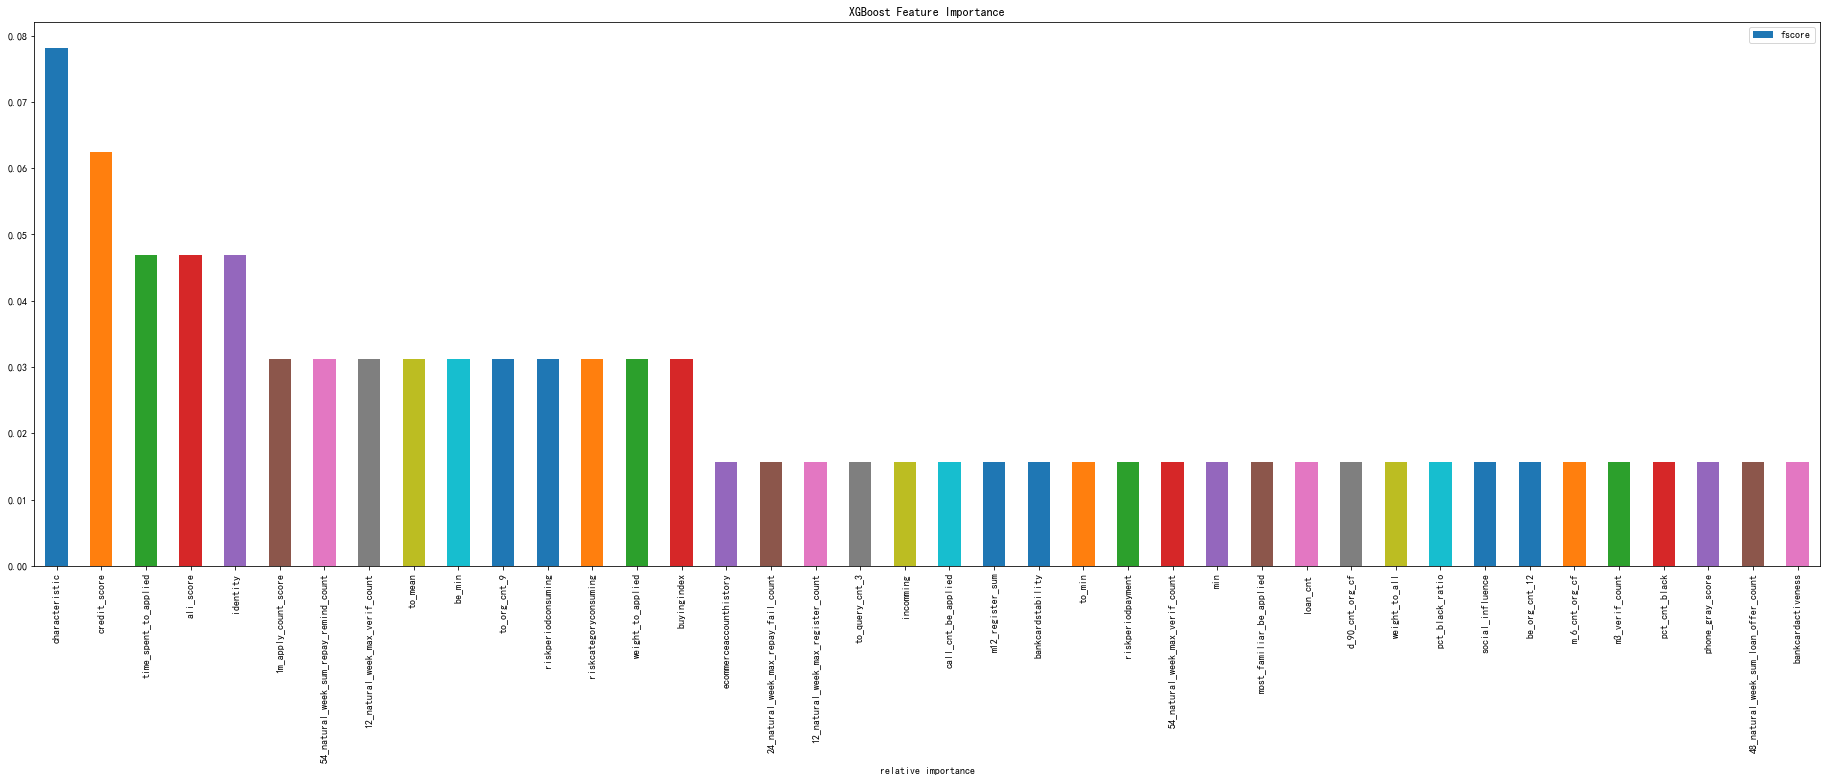

In [29]:
#运行XGBoost,输出特征重要性排名
def run_xgboost(data_x,data_y,random_state_num):
    train_x,valid_x,train_y,valid_y = train_test_split(data_x.values,data_y.values,test_size=0.25,random_state=random_state_num)
    print('开始训练模型')
    start = time.time()
    #转换成xgb运算格式
    d_train = xgb.DMatrix(train_x,train_y)
    d_valid = xgb.DMatrix(valid_x,valid_y)
    watchlist = [(d_train,'train'),(d_valid,'valid')]
    #参数设置（未调箱前的参数）
    params={
        'eta':0.2,                        #特征权重，取值范围0~1，通常最后设置eta为0.01~0.2
        'max_depth':4,                    #树的深度，通常取值3-10，过大容易过拟合，过小欠拟合
        'min_child_weight':1,             #最小样本的权重，调大参数可以繁殖过拟合
        'gamma':0.4,                      #控制是否后剪枝，越大越保守，一般0.1、 0.2的样子
        'subsample':0.8,                  #随机取样比例
        'colsample_bytree':0.8 ,          #默认为1，取值0~1，对特征随机采集比例
        'reg_lambda':0.8,
        'reg_alpha':0.2,
        'learning_rate':0.01,
        'n_estimators':800,
        'booster':'gbtree',               #迭代树
        'objective':'binary:logistic',    #逻辑回归，输出为概率
        'nthread':6,                      #设置最大的进程量，若不设置则会使用全部资源
        'scale_pos_weight':1,             #默认为0,1可以处理类别不平衡
        'lambda':1,                       #默认为1，用于L2平滑处理项，避免模型过拟合
        'seed':1234,                      #随机树种子
        'silent':1,                       #0表示输出结果
        'eval_metric':'auc'               #评分指标
    }
    bst = xgb.train(params, d_train,1000,watchlist,early_stopping_rounds=100, verbose_eval=5)   #最大迭代次数1000次
    print(time.time()-start)
    tree_nums = bst.best_ntree_limit
    print('最优模型树的数量：%s,最优迭代次数：%s,auc: %s' %(bst.best_ntree_limit,bst.best_iteration,bst.best_score))
    bst = xgb.train(params, d_train,tree_nums,watchlist,early_stopping_rounds=100, verbose_eval=10) #最优模型迭代次数去训练
    
#     feat_imp = pd.Series(clf.booster().get_fscore()).sort_values(ascending=False)
#     #新版需要转换成dict or list 
#     #feat_imp = pd.Series(dict(clf.get_booster().get_fscore())).sort_values(ascending=False)
#     #plt.bar(feat_imp.index, feat_imp)
#     feat_imp.plot(kind='bar', title='Feature Importances')
    #展示特征重要性排名
    feat_imp = bst.get_fscore(fmap='xgb.txt')
    feat_imp = sorted(feat_imp.items(),key=operator.itemgetter(1))
    print(feat_imp)
    df = pd.DataFrame(feat_imp,columns=['feature','fscore'])
    #每个特征被调用的次数/所有特征被调用总次数
    df['fscore'] = df['fscore']/df['fscore'].sum()
    #分数高的排在前面,展示前40个重要特征排名
    df = df.sort_values(by='fscore',ascending=False)
    df = df.iloc[:40]
    plt.figure()
    df.plot(kind='bar',x='feature',y='fscore',legend=True,figsize=(32,10))
    plt.title('XGBoost Feature Importance')
    plt.xlabel('relative importance')
    plt.gcf().savefig('feature_importance_xgb.png')
    plt.show()
    return bst 

run_xgboost(data_x,data_y,100)

开始训练模型
[0]	train-auc:0.63384	valid-auc:0.51179
Multiple eval metrics have been passed: 'valid-auc' will be used for early stopping.

Will train until valid-auc hasn't improved in 100 rounds.
[5]	train-auc:0.76323	valid-auc:0.54922
[10]	train-auc:0.78215	valid-auc:0.54689
[15]	train-auc:0.81566	valid-auc:0.59753
[20]	train-auc:0.82239	valid-auc:0.60245
[25]	train-auc:0.82049	valid-auc:0.59658
[30]	train-auc:0.83585	valid-auc:0.59852
[35]	train-auc:0.83452	valid-auc:0.59045
[40]	train-auc:0.83593	valid-auc:0.59188
[45]	train-auc:0.83883	valid-auc:0.58484
[50]	train-auc:0.85331	valid-auc:0.58630
[55]	train-auc:0.85537	valid-auc:0.58104
[60]	train-auc:0.86187	valid-auc:0.58734
[65]	train-auc:0.86955	valid-auc:0.59097
[70]	train-auc:0.87609	valid-auc:0.59321
[75]	train-auc:0.87512	valid-auc:0.59364
[80]	train-auc:0.88177	valid-auc:0.59874
[85]	train-auc:0.89162	valid-auc:0.60003
[90]	train-auc:0.89738	valid-auc:0.59494
[95]	train-auc:0.90284	valid-auc:0.59330
[100]	train-auc:0.90861	valid-a

<Figure size 432x288 with 0 Axes>

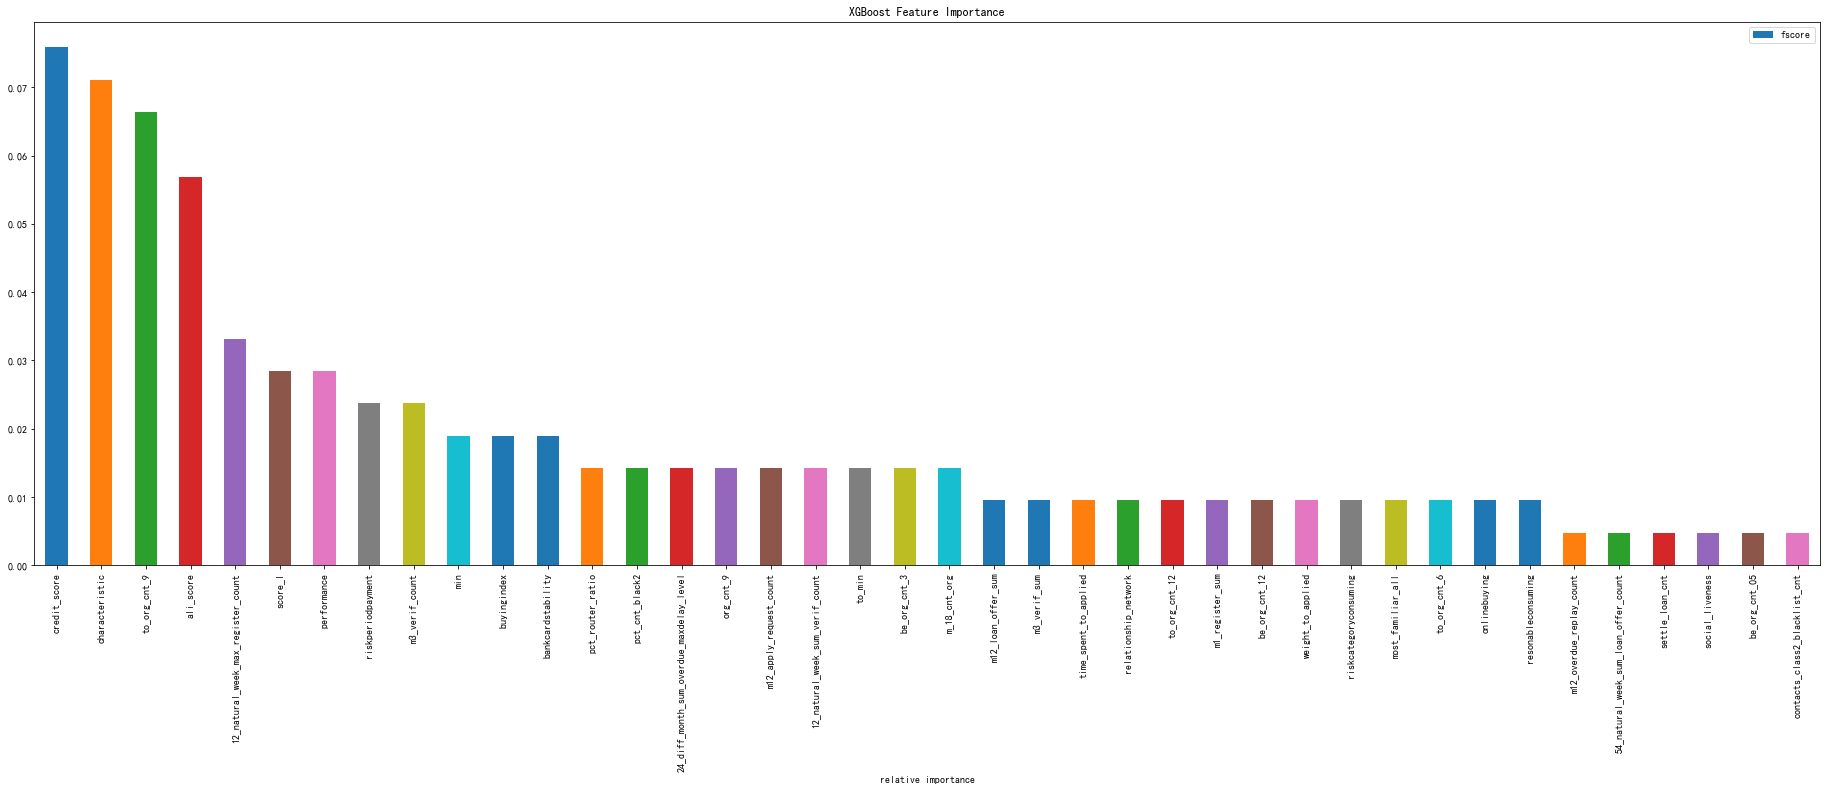

模型已成功保存在 ./xgboost_model


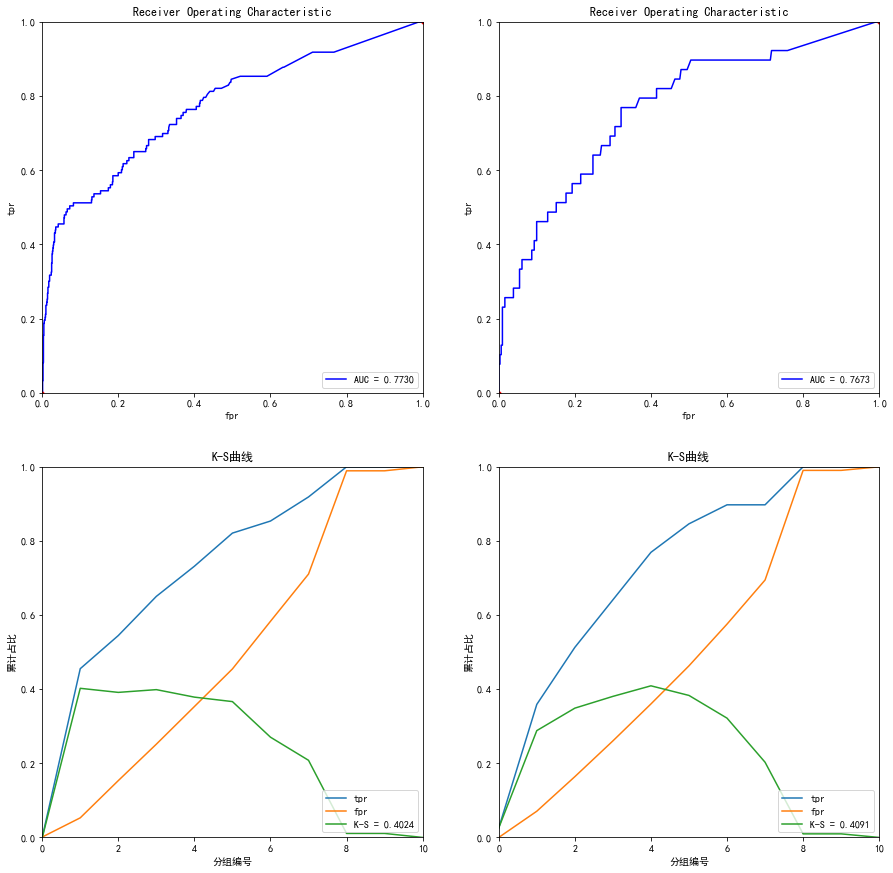

模型评价指标已保存在：./xgboost_model_auc_ks.png
运行共花费时间：2.726710319519043


In [30]:
# 绘制ROC曲线函数
def plot_roc(test_x, test_y):
    predictions = bst.predict(xgb.DMatrix(test_x))
    false_positive_rate, true_positive_rate, thresholds = roc_curve(test_y, predictions)  #roc的几个参数
    roc_auc = auc(false_positive_rate, true_positive_rate)  #直接计算auc
    plt.title('Receiver Operating Characteristic')
    plt.plot(false_positive_rate,true_positive_rate, 'b', label='AUC = %0.4f' % roc_auc)
    plt.legend(loc='lower right')
    plt.plot([0, 1], [0, 1], 'r.')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])
    plt.ylabel('tpr')
    plt.xlabel('fpr')

# 绘制K-S函数 从大到小排序，分10等分
def plot_ks(test_x, test_y):
    predictions = bst.predict(xgb.DMatrix(test_x))
    false_positive_rate, true_positive_rate, thresholds = roc_curve(test_y, predictions, drop_intermediate=False)
    pre = sorted(predictions, reverse=True)  #reverse参数为True意味着按照降序排序，这是画ks时要求的
    num = []
    for i in range(10):
        num.append((i) * int(len(pre) / 10))
    num.append(len(pre) - 1)
    df = pd.DataFrame()
    df['false_positive_rate'] = false_positive_rate
    df['true_positive_rate'] = true_positive_rate
    df['thresholds'] = thresholds
    data_ks = []
    for i in num:
        data_ks.append(list(df[df['thresholds'] == pre[i]].values[0]))
    data_ks = pd.DataFrame(data_ks)
    data_ks.columns = ['fpr', 'tpr', 'thresholds']
    ks = max(data_ks['tpr'] - data_ks['fpr'])
    plt.title('K-S曲线')
    plt.plot(np.array(range(len(num))), data_ks['tpr'])
    plt.plot(np.array(range(len(num))), data_ks['fpr'])
    plt.plot(np.array(range(len(num))), data_ks['tpr'] - data_ks['fpr'], label='K-S = %0.4f' % ks)
    plt.legend(loc='lower right')
    plt.xlim([0, 10])
    plt.ylim([0.0, 1.0])
    plt.ylabel('累计占比')
    plt.xlabel('分组编号')

# 绘制一张图，包含训练和测试集的ROC、AUC、K-S图形指标。
def auc_ks(train_x, test_x, train_y, test_y):
    plt.figure(figsize=(15, 15))
    plt.subplot(221)
    plot_roc(train_x, train_y)
    plt.subplot(222)
    plot_roc(test_x, test_y)
    plt.subplot(223)
    plot_ks(train_x, train_y)
    plt.subplot(224)
    plot_ks(test_x, test_y)
    plt.savefig(file_xgboost_model_auc_ks)
    plt.show()

#保存模型、评价指标、选择变量到D盘
def run_main(data_x,data_y):
    global bst
    start=time.time()
    bst=run_xgboost(data_x,data_y,random_state_num=1234)  #为什么要是1234，因为调参时候就是=1234
    joblib.dump(bst, file_xgboost_model)  #joblib的用法https://www.cnblogs.com/wzdLY/p/9630671.html 将模型保存
    print('模型已成功保存在 %s'%(file_xgboost_model))
    train_x, test_x, train_y, test_y = train_test_split(data_x.values, data_y.values, test_size=0.25, random_state=100)
    auc_ks(train_x, test_x, train_y, test_y)
    print('模型评价指标已保存在：%s'%(file_xgboost_model_auc_ks))
    print('运行共花费时间：%s'%(time.time()-start))

if __name__=='__main__':
    run_main(train_x, train_y)

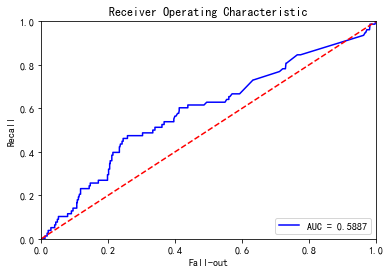

In [26]:
# 绘制ROC曲线函数
def plot_test_roc(test_x, test_y,filename):
    bst = joblib.load(filename)
    predictions = bst.predict(xgb.DMatrix(test_x.values))
    false_positive_rate,true_positive_rate, thresholds = roc_curve(test_y, predictions)
    roc_auc = auc(false_positive_rate, true_positive_rate)
    plt.title('Receiver Operating Characteristic')
    plt.plot(false_positive_rate,true_positive_rate, 'b', label='AUC = %0.4f' % roc_auc)
    plt.legend(loc='lower right')
    plt.plot([0, 1], [0, 1], 'r--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])
    plt.ylabel('Recall')
    plt.xlabel('Fall-out')
    plt.show()

if __name__=='__main__':
    plot_test_roc(valid_x,valid_y,file_xgboost_model)